In [1]:
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# my gpu cfg

In [2]:
import tensorflow as tf
# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 
tf.config.set_soft_device_placement(True)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2023-03-20 11:13:39.143634: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 11:13:40.861681: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/emre/anaconda3/envs/emre_venv/lib/
2023-03-20 11:13:40.861843: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/emre/anaconda3/envs/emre_venv/lib/
2023-03-20 11:13:40.861861: W tensorflow/comp

Num GPUs Available:  1


# IMPORTS

In [3]:
print("\n... PIP INSTALLS STARTING ...\n")
# !pip install -q --upgrade tensorflow-io
try:
    import mediapipe as mp
except:
#     !pip install -q mediapipe
    import mediapipe as mp
print("\n... PIP INSTALLS COMPLETE ...\n")

# !pip install lion-tf
print("\n... IMPORTS STARTING ...\n")
print("\n\tVERSION INFORMATION")

# Machine Learning and Data Science Imports (basics)
import tensorflow as tf; print(f"\t\t– TENSORFLOW VERSION: {tf.__version__}");
import tensorflow_io as tfio; print(f"\t\t– TENSORFLOW-IO VERSION: {tfio.__version__}");
import pandas as pd; pd.options.mode.chained_assignment = None; pd.set_option('display.max_columns', None);
import numpy as np; print(f"\t\t– NUMPY VERSION: {np.__version__}");
import sklearn; print(f"\t\t– SKLEARN VERSION: {sklearn.__version__}");

# Built-In Imports (mostly don't worry about these)
# from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import train_test_split
from livelossplot import PlotLossesKerasTF
from collections import Counter
from datetime import datetime
from zipfile import ZipFile
from tqdm import tqdm
from glob import glob
# import Levenshtein
import warnings
import requests
import hashlib
# import imageio
import IPython
import sklearn
import urllib
import zipfile
import pickle
import random
import shutil
import string
import json
import math
import time
import gzip
import ast
import sys
import io
import os
import gc
import re

def seed_it_all(seed=7):
    """ Attempt to be Reproducible """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_it_all()

print("\n\n... IMPORTS COMPLETE ...\n")


... PIP INSTALLS STARTING ...


... PIP INSTALLS COMPLETE ...


... IMPORTS STARTING ...


	VERSION INFORMATION
		– TENSORFLOW VERSION: 2.11.0
		– TENSORFLOW-IO VERSION: 0.31.0
		– NUMPY VERSION: 1.23.3
		– SKLEARN VERSION: 1.1.2


... IMPORTS COMPLETE ...



# SETUP

### HELPER FUNCTIONS

In [4]:
def read_json_file(file_path):
    try:
        # Open the file and load the JSON data into a Python object
        with open(file_path, 'r') as file:
            json_data = json.load(file)
        return json_data
    except FileNotFoundError:
        # Raise an error if the file path does not exist
        raise FileNotFoundError(f"File not found: {file_path}")
    except ValueError:
        # Raise an error if the file does not contain valid JSON data
        raise ValueError(f"Invalid JSON data in file: {file_path}")

ROWS_PER_FRAME = 543  # number of landmarks per frame
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

### LOAD DATA

In [5]:
# Define the path to the root data directory
DATA_DIR         = "../data"

print("\n... BASIC DATA SETUP STARTING ...\n")
print("\n\n... LOAD TRAIN DATAFRAME FROM CSV FILE ...\n")

train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
train_df["path"] = DATA_DIR+"/"+train_df["path"]
display(train_df.head())

print("\n\n... LOAD SIGN TO PREDICTION INDEX MAP FROM JSON FILE ...\n")
s2p_map = {k.lower():v for k,v in read_json_file(os.path.join(DATA_DIR, "sign_to_prediction_index_map.json")).items()}
p2s_map = {v:k for k,v in read_json_file(os.path.join(DATA_DIR, "sign_to_prediction_index_map.json")).items()}
encoder = lambda x: s2p_map.get(x.lower())
decoder = lambda x: p2s_map.get(x)
print(s2p_map)


... BASIC DATA SETUP STARTING ...



... LOAD TRAIN DATAFRAME FROM CSV FILE ...



,path,participant_id,sequence_id,sign
0,../data/train_landmark_files/26734/1000035562....,26734,1000035562,blow
1,../data/train_landmark_files/28656/1000106739....,28656,1000106739,wait
2,../data/train_landmark_files/16069/100015657.p...,16069,100015657,cloud
3,../data/train_landmark_files/25571/1000210073....,25571,1000210073,bird
4,../data/train_landmark_files/62590/1000240708....,62590,1000240708,owie




... LOAD SIGN TO PREDICTION INDEX MAP FROM JSON FILE ...

{'tv': 0, 'after': 1, 'airplane': 2, 'all': 3, 'alligator': 4, 'animal': 5, 'another': 6, 'any': 7, 'apple': 8, 'arm': 9, 'aunt': 10, 'awake': 11, 'backyard': 12, 'bad': 13, 'balloon': 14, 'bath': 15, 'because': 16, 'bed': 17, 'bedroom': 18, 'bee': 19, 'before': 20, 'beside': 21, 'better': 22, 'bird': 23, 'black': 24, 'blow': 25, 'blue': 26, 'boat': 27, 'book': 28, 'boy': 29, 'brother': 30, 'brown': 31, 'bug': 32, 'bye': 33, 'callonphone': 34, 'can': 35, 'car': 36, 'carrot': 37, 'cat': 38, 'cereal': 39, 'chair': 40, 'cheek': 41, 'child': 42, 'chin': 43, 'chocolate': 44, 'clean': 45, 'close': 46, 'closet': 47, 'cloud': 48, 'clown': 49, 'cow': 50, 'cowboy': 51, 'cry': 52, 'cut': 53, 'cute': 54, 'dad': 55, 'dance': 56, 'dirty': 57, 'dog': 58, 'doll': 59, 'donkey': 60, 'down': 61, 'drawer': 62, 'drink': 63, 'drop': 64, 'dry': 65, 'dryer': 66, 'duck': 67, 'ear': 68, 'elephant': 69, 'empty': 70, 'every': 71, 'eye': 72, 'face': 73, '

## Configuration

In [6]:
DROP_Z = False

NUM_FRAMES1 = 15 # 15 for feature_data.npy
SEGMENTS = 3

num_face = 468
num_lhand = 21
num_pose = 33
num_rhand = 21


LEFT_HAND_OFFSET = num_face
POSE_OFFSET = LEFT_HAND_OFFSET + num_lhand
RIGHT_HAND_OFFSET = POSE_OFFSET + num_pose

## average over the entire face, and the entire 'pose'
averaging_sets = [[0, 468], [POSE_OFFSET, 33]]

lip_landmarks = [61, 185, 40, 39, 37,  0, 267, 269, 270, 409,
                 291,146, 91,181, 84, 17, 314, 405, 321, 375, 
                 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 
                 95, 88, 178, 87, 14,317, 402, 318, 324, 308]
left_hand_landmarks = list(range(LEFT_HAND_OFFSET, LEFT_HAND_OFFSET + num_lhand))
all_pose_landmarks = list(range(POSE_OFFSET, POSE_OFFSET + num_pose))
pose_relavant_landmarks = [11, 13, 15, 17, 19, 21,
                           12, 14, 16, 18, 20, 22]
pose_landmarks = [all_pose_landmarks[p] for p in pose_relavant_landmarks]

right_hand_landmarks = list(range(RIGHT_HAND_OFFSET, RIGHT_HAND_OFFSET + num_rhand))

# point_landmarks = [item for sublist in [lip_landmarks, left_hand_landmarks, pose_landmarks, right_hand_landmarks] for item in sublist]
point_landmarks = [item for sublist in [lip_landmarks, left_hand_landmarks, right_hand_landmarks] for item in sublist]

LANDMARKS1 = len(point_landmarks) + len(averaging_sets)
print(LANDMARKS1)

if DROP_Z:
    INPUT_SHAPE1 = (NUM_FRAMES1,LANDMARKS1*2)
else:
    INPUT_SHAPE1 = (NUM_FRAMES1,LANDMARKS1*3)

FLAT_INPUT_SHAPE1 = (INPUT_SHAPE1[0] + 2 * (SEGMENTS + 1)) * INPUT_SHAPE1[1]
    

84


## Helper Functions

In [7]:
def tf_nan_mean(x, axis=0):
    return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis) / tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis)

def tf_nan_std(x, axis=0):
    d = x - tf_nan_mean(x, axis=axis)
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis))

def flatten_means_and_stds1(x, axis=0):
    # Get means and stds
    x_mean = tf_nan_mean(x, axis=0)
    x_std  = tf_nan_std(x,  axis=0)

    x_out = tf.concat([x_mean, x_std], axis=0)
    x_out = tf.reshape(x_out, (1, INPUT_SHAPE1[1]*2))
    x_out = tf.where(tf.math.is_finite(x_out), x_out, tf.zeros_like(x_out))
    return x_out

## TensorFlow Feature Preprocessing Layer

In [8]:
class FeatureGen(tf.keras.layers.Layer):
    def __init__(self):
        super(FeatureGen, self).__init__()
    
    def call(self, x_in):
        if DROP_Z:
            x_in = x_in[:, :, 0:2]
        x_list = [tf.expand_dims(tf_nan_mean(x_in[:, av_set[0]:av_set[0]+av_set[1], :], axis=1), axis=1) for av_set in averaging_sets]
        x_list.append(tf.gather(x_in, point_landmarks, axis=1))
        x = tf.concat(x_list, 1)

        x_padded = x
        for i in range(SEGMENTS):
            p0 = tf.where( ((tf.shape(x_padded)[0] % SEGMENTS) > 0) & ((i % 2) != 0) , 1, 0)
            p1 = tf.where( ((tf.shape(x_padded)[0] % SEGMENTS) > 0) & ((i % 2) == 0) , 1, 0)
            paddings = [[p0, p1], [0, 0], [0, 0]]
            x_padded = tf.pad(x_padded, paddings, mode="SYMMETRIC")
        x_list = tf.split(x_padded, SEGMENTS)
        x_list = [flatten_means_and_stds1(_x, axis=0) for _x in x_list]

        x_list.append(flatten_means_and_stds1(x, axis=0))
        
        ## Resize only dimension 0. Resize can't handle nan, so replace nan with that dimension's avg value to reduce impact.
        x = tf.image.resize(tf.where(tf.math.is_finite(x), x, tf_nan_mean(x, axis=0)), [NUM_FRAMES1, LANDMARKS1])
        x = tf.reshape(x, (1, INPUT_SHAPE1[0]*INPUT_SHAPE1[1]))
        x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
        x_list.append(x)
        x = tf.concat(x_list, axis=1)
        return x

# print(FeatureGen()(tf.keras.Input((543, 3), dtype=tf.float32, name="inputs")))
tensor = FeatureGen()(load_relevant_data_subset(train_df.path[0]))
print(tensor.shape)

(1, 5796)


2023-03-20 11:13:44.583980: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 11:13:45.623706: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-03-20 11:13:45.623800: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9944 MB memory:  -> device: 0, name: TITAN V, pci bus id: 0000:83:00.0, compute capability: 7.0


# Load data

In [9]:
# train_x    = np.load("datasets/my_feature_data_numframes" + str(NUM_FRAMES1) + ".npy").astype(np.float32)
# train_y    = np.load("datasets/my_feature_labels_numframes" + str(NUM_FRAMES1) + ".npy").astype(np.uint8)
# train_x    = np.load("datasets/my_feature_data.npy").astype(np.float32)
# train_y    = np.load("datasets/my_feature_labels.npy").astype(np.uint8)
train_x    = np.load("datasets/feature_data.npy").astype(np.float32)
train_y    = np.load("datasets/feature_labels.npy").astype(np.uint8)
print(train_x.shape, train_y.shape)

(94477, 5796) (94477,)


In [10]:
train_index, test_index = train_test_split(list(range(len(train_x))), test_size = 0.05,random_state=1)
print(len(train_index), ', ', len(test_index))

89753 ,  4724


## Hyperparams

In [11]:
BATCH_SIZE = 128
VAL_PCT = 0.1
LEARNING_RATE = 0.000333
LR_PATIENCE = 2
LR_REDUCTION_FACTOR = 0.8
EPOCHS = 200

STARTING_LAYER_SIZE = 1426
DROPOUTS = [0.5,0.5]

## Callbacks

In [12]:
cb_list = [
    tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor='val_acc'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=LR_PATIENCE, factor=LR_REDUCTION_FACTOR, verbose=0),
    PlotLossesKerasTF()
]

## FCN

In [13]:
def fc_block(inputs, output_channels, dropout=0.2, activation="gelu"):
    x = tf.keras.layers.Dense(output_channels)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    return x

In [14]:
def get_model(n_labels=250, init_fc=STARTING_LAYER_SIZE, flat_frame_len=train_x.shape[1]):
    
    _inputs = tf.keras.layers.Input(shape=(flat_frame_len,))
    x = _inputs

    for i in range(len(DROPOUTS)):
        x = fc_block(
            x, output_channels=init_fc//(2**i), 
            dropout=DROPOUTS[i]
        )

    _outputs = tf.keras.layers.Dense(n_labels, activation="softmax", name='outputs')(x)

    model = tf.keras.models.Model(inputs=_inputs, outputs=_outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer, "sparse_categorical_crossentropy", metrics="acc")
#     model.summary()
#     tf.keras.utils.plot_model(model)
    return model

## Train

In [26]:
model = get_model()

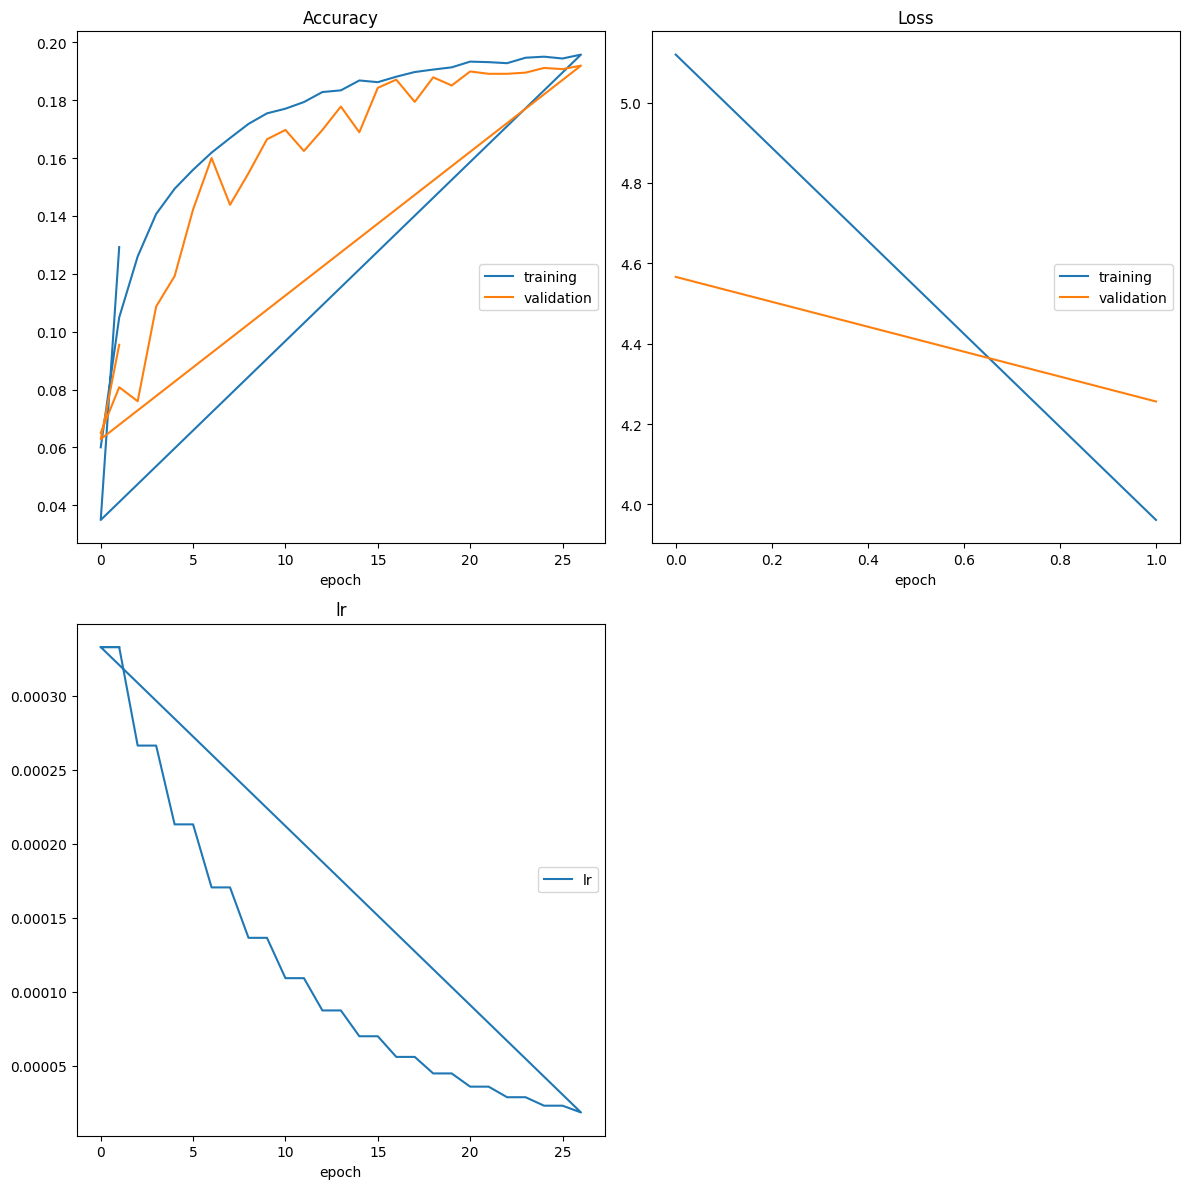

Accuracy
	training         	 (min:    0.035, max:    0.196, cur:    0.129)
	validation       	 (min:    0.063, max:    0.192, cur:    0.095)
Loss
	training         	 (min:      nan, max:      nan, cur:    3.962)
	validation       	 (min:      nan, max:      nan, cur:    4.256)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
702/702 [==============================] - 11s 16ms/step - loss: 3.9615 - acc: 0.1292 - val_loss: 4.2563 - val_acc: 0.0955 - lr: 3.3300e-04
Epoch 3/200
423/702 [=================>............] - ETA: 3s - loss: 3.4390 - acc: 0.2050

KeyboardInterrupt: 

In [27]:
history = model.fit(train_x[train_index], train_y[train_index],
                    validation_data=(train_x[test_index], train_y[test_index]),
                    epochs=EPOCHS, callbacks=cb_list, batch_size=BATCH_SIZE)

In [47]:
### eval
loss, acc = model.evaluate(train_x[test_index], train_y[test_index])
print(acc*100)

148/148 [==============================] - 1s 5ms/step - loss: 1.1346 - acc: 0.7227
72.2692608833313


## Save model

In [48]:
model_name = 'models/gislr_allposes_acc' + str(round(acc*100, 2)) + '.h5'
model.save(model_name)
print(model_name, 'saved.')

models/gislr_allposes_acc72.27.h5 saved.


In [36]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5796)]            0         
                                                                 
 dense (Dense)               (None, 1426)              8266522   
                                                                 
 batch_normalization (BatchN  (None, 1426)             5704      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1426)              0         
                                                                 
 dropout (Dropout)           (None, 1426)              0         
                                                                 
 dense_1 (Dense)             (None, 713)               1017451   
                                                             

## Get inference model

In [15]:
load_model_name = 'models/my_gislr_acc72.27.h5'
loaded_model = tf.keras.models.load_model(load_model_name)

In [16]:
tf.keras.utils.plot_model(loaded_model)
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5796)]            0         
                                                                 
 dense (Dense)               (None, 1426)              8266522   
                                                                 
 batch_normalization (BatchN  (None, 1426)             5704      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1426)              0         
                                                                 
 dropout (Dropout)           (None, 1426)              0         
                                                                 
 dense_1 (Dense)             (None, 713)               1017451   
                                                             

In [17]:
loss, acc = loaded_model.evaluate(train_x[test_index], train_y[test_index])

148/148 [==============================] - 2s 7ms/step - loss: 1.1346 - acc: 0.7227


## TFLite Model

In [18]:
class TFLiteModel(tf.Module):
    """
    TensorFlow Lite model that takes input tensors and applies:
        – a preprocessing model
        – the ISLR model 
    """

    def __init__(self, feature_model, islr_model):
        """
        Initializes the TFLiteModel with the specified preprocessing model and ISLR model.
        """
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.prep_inputs = feature_model
        self.islr_model  = islr_model
        
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 543, 3], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        """
        Applies the feature generation model and main model to the input tensors.

        Args:
            inputs: Input tensor with shape [batch_size, 543, 3].

        Returns:
            A dictionary with a single key 'outputs' and corresponding output tensor.
        """
        
        
#         inputs = self.input_layer()(tf.cast(inputs, dtype=tf.float32))
        x = self.prep_inputs(inputs)
#         print(x.shape)
        outputs = self.islr_model(x)
        
#         outputs  = tf.concat([_model(x) for _model in self.islr_fold_models], axis=0)
        
#         # Compute the weighted sum and the sum of the weights and compute the weighted mean
#         outputs = tf.reduce_sum(tf.multiply(outputs, self.model_weights), axis=0)
#         outputs = tf.divide(outputs, tf.reduce_sum(self.model_weights, axis=0))
        
        # Return a dictionary with the output tensor
        return {'outputs': outputs}

In [21]:
inference_model = TFLiteModel(FeatureGen(), loaded_model)

In [24]:
# test inference model
data_path = "../data/"
train_csv = pd.read_csv(f"{data_path}train.csv")

frames = load_relevant_data_subset(f'{data_path}/{train_csv.iloc[0].path}')
print(frames.shape)
# preds = inference_model.predict(frames)
preds = inference_model(frames)
print(preds['outputs'].shape)

(23, 543, 3)
(1, 250)


## Create submission file

In [112]:
converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
tflite_model = converter.convert()
model_path = "model.tflite"
# Save the model.
with open(model_path, 'wb') as f:
    f.write(tflite_model)
!zip submission.zip $model_path

(1, 5796)


INFO:tensorflow:Assets written to: /tmp/tmpq56xbhwu/assets


INFO:tensorflow:Assets written to: /tmp/tmpq56xbhwu/assets
2023-03-19 20:23:50.750427: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-03-19 20:23:50.750474: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-03-19 20:23:50.751950: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpq56xbhwu
2023-03-19 20:23:50.760269: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-03-19 20:23:50.760308: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpq56xbhwu
2023-03-19 20:23:50.791279: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-03-19 20:23:50.794689: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-03-19 20:23:51.012577: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

updating: model.tflite (deflated 7%)


## Making Predictions

In [71]:
# !pip install tflite-runtime

In [15]:
def read_dict(file_path):
    path = os.path.expanduser(file_path)
    with open(path, "r") as f:
        dic = json.load(f)
    return dic

In [26]:
data_path = "../data/"
train_csv = pd.read_csv(f"{data_path}train.csv")
train_csv.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [27]:
from tqdm import tqdm

In [28]:
label_index = read_dict(f"{data_path}sign_to_prediction_index_map.json")
index_label = dict([(label_index[key], key) for key in label_index])
print('Num. of classes: ', len(label_index))
train_csv["label"] = train_csv["sign"].map(lambda sign: label_index[sign])

Num. of classes:  250


## gislr eval

In [76]:
import tflite_runtime.interpreter as tflite
interpreter = tflite.Interpreter('model.tflite')
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")
for i in range(20):
    frames = load_relevant_data_subset(f'{data_path}/{train_csv.iloc[i].path}')
    output = prediction_fn(inputs=frames)
    sign = np.argmax(output["outputs"])
#     output = inference_model(inputs=frames)
#     sign = np.argmax(output)
#     print(sign)
    print(f"Predicted label: {index_label[sign]}, Actual Label: {train_csv.iloc[i].sign}")

Predicted label: blow, Actual Label: blow
Predicted label: wait, Actual Label: wait
Predicted label: cloud, Actual Label: cloud
Predicted label: bird, Actual Label: bird
Predicted label: owie, Actual Label: owie
Predicted label: duck, Actual Label: duck
Predicted label: minemy, Actual Label: minemy
Predicted label: lips, Actual Label: lips
Predicted label: flower, Actual Label: flower
Predicted label: lion, Actual Label: time
Predicted label: vacuum, Actual Label: vacuum
Predicted label: apple, Actual Label: apple
Predicted label: puzzle, Actual Label: puzzle
Predicted label: mitten, Actual Label: mitten
Predicted label: there, Actual Label: there
Predicted label: dry, Actual Label: dry
Predicted label: shirt, Actual Label: shirt
Predicted label: owl, Actual Label: owl
Predicted label: yellow, Actual Label: yellow
Predicted label: drop, Actual Label: time


In [29]:
pred_ls = []
gt_ls = []
# train_x[test_index], train_y[test_index]
for i, idx in tqdm(enumerate(test_index), position=0):
#     output = inference_model.predict(load_relevant_data_subset(f'{data_path}/{train_csv.iloc[idx].path}'), verbose=0)
    output = inference_model(load_relevant_data_subset(f'{data_path}/{train_csv.iloc[idx].path}'))
    sign = np.argmax(output['outputs'])
    pred_ls.append(sign)
    gt_ls.append(train_y[idx])
#     break
assert(len(pred_ls) == len(gt_ls))

4724it [01:19, 59.48it/s]


In [30]:
acc = np.sum([1 for i in range(len(gt_ls)) if gt_ls[i] == pred_ls[i]]) / len(gt_ls) * 100
acc

72.2692633361558

## confusion matrix

In [31]:
from collections import Counter

In [32]:
num_class = 250 # len(np.unique(gt_ls))
num_selectclass = 64

In [33]:
cf = sklearn.metrics.confusion_matrix(gt_ls, pred_ls)
diags = np.diagonal(cf)
num_samples_per_class = Counter(gt_ls)
classwise_acc = [round(diags[i] / num_samples_per_class[i] * 100, 2) for i in range(num_class)]
sorted_ls = sorted(range(len(classwise_acc)), key=classwise_acc.__getitem__, reverse=True)
select_classes = sorted_ls[:num_selectclass]
select_classes_str = [index_label[s] for s in select_classes]
select_classes_dict = dict(zip(select_classes_str, select_classes))

In [34]:
classwise_acc[sorted_ls[0]]

100.0

In [35]:
with open("chess_classes64.json", "w") as outfile:
    json.dump(select_classes_dict, outfile)

## Train for 64 signs

In [16]:
select_classes_dict = read_dict("chess_classes64.json")
select_classes = select_classes_dict.values()

In [17]:
select_indices = [i for i in range(len(train_y)) if train_y[i] in select_classes]
train_x64 = train_x[select_indices]
train_y64 = train_y[select_indices]
print(train_x64.shape)
print(train_y64.shape)

(24741, 5796)
(24741,)


In [18]:
train_index64, test_index64 = train_test_split(range(len(train_y64)), test_size=0.1, random_state=1)

In [35]:
class_map = dict(zip(np.unique(train_y64), list(range(len(np.unique(train_y64))))))
train_y64_mapped = np.array([class_map[y] for y in train_y64])
print(len(np.unique(train_y64_mapped)))
print(class_map)

64
{2: 0, 10: 1, 24: 2, 25: 3, 29: 4, 31: 5, 32: 6, 34: 7, 44: 8, 49: 9, 50: 10, 60: 11, 63: 12, 67: 13, 72: 14, 75: 15, 77: 16, 82: 17, 83: 18, 85: 19, 87: 20, 88: 21, 92: 22, 100: 23, 103: 24, 114: 25, 118: 26, 119: 27, 120: 28, 122: 29, 133: 30, 140: 31, 145: 32, 147: 33, 151: 34, 154: 35, 156: 36, 157: 37, 158: 38, 159: 39, 162: 40, 163: 41, 172: 42, 174: 43, 182: 44, 189: 45, 190: 46, 193: 47, 194: 48, 195: 49, 197: 50, 201: 51, 207: 52, 209: 53, 218: 54, 219: 55, 220: 56, 227: 57, 228: 58, 234: 59, 237: 60, 243: 61, 246: 62, 248: 63}


In [34]:
class_dict_0_to_63 = dict()

for i in select_classes_dict.keys():
    class_dict_0_to_63[i] = class_map[select_classes_dict[i]]
class_dict_0_to_63

{'first': 18,
 'flag': 19,
 'nuts': 38,
 'orange': 40,
 'radio': 44,
 'uncle': 58,
 'airplane': 0,
 'police': 43,
 'aunt': 1,
 'eye': 14,
 'boy': 4,
 'sad': 45,
 'shower': 50,
 'stuck': 53,
 'blow': 3,
 'brown': 5,
 'home': 26,
 'morning': 33,
 'see': 47,
 'clown': 9,
 'gum': 24,
 'callonphone': 7,
 'donkey': 11,
 'lion': 30,
 'tree': 57,
 'yourself': 62,
 'zebra': 63,
 'black': 2,
 'drink': 12,
 'icecream': 29,
 'mom': 32,
 'noisy': 35,
 'now': 37,
 'chocolate': 8,
 'water': 59,
 'old': 39,
 'fireman': 17,
 'food': 20,
 'shirt': 49,
 'time': 56,
 'where': 60,
 'farm': 15,
 'feet': 16,
 'hen': 25,
 'horse': 27,
 'thirsty': 54,
 'same': 46,
 'tiger': 55,
 'grandpa': 23,
 'napkin': 34,
 'shhh': 48,
 'smile': 51,
 'store': 52,
 'bug': 6,
 'duck': 13,
 'for': 21,
 'man': 31,
 'pizza': 42,
 'yellow': 61,
 'cow': 10,
 'gift': 22,
 'hot': 28,
 'not': 36,
 'outside': 41}

In [37]:
with open("chess_classes_0_to_63.json", "w") as outfile:
    json.dump(select_classes_dict, outfile)

## Train

In [23]:
model = get_model(n_labels=64)

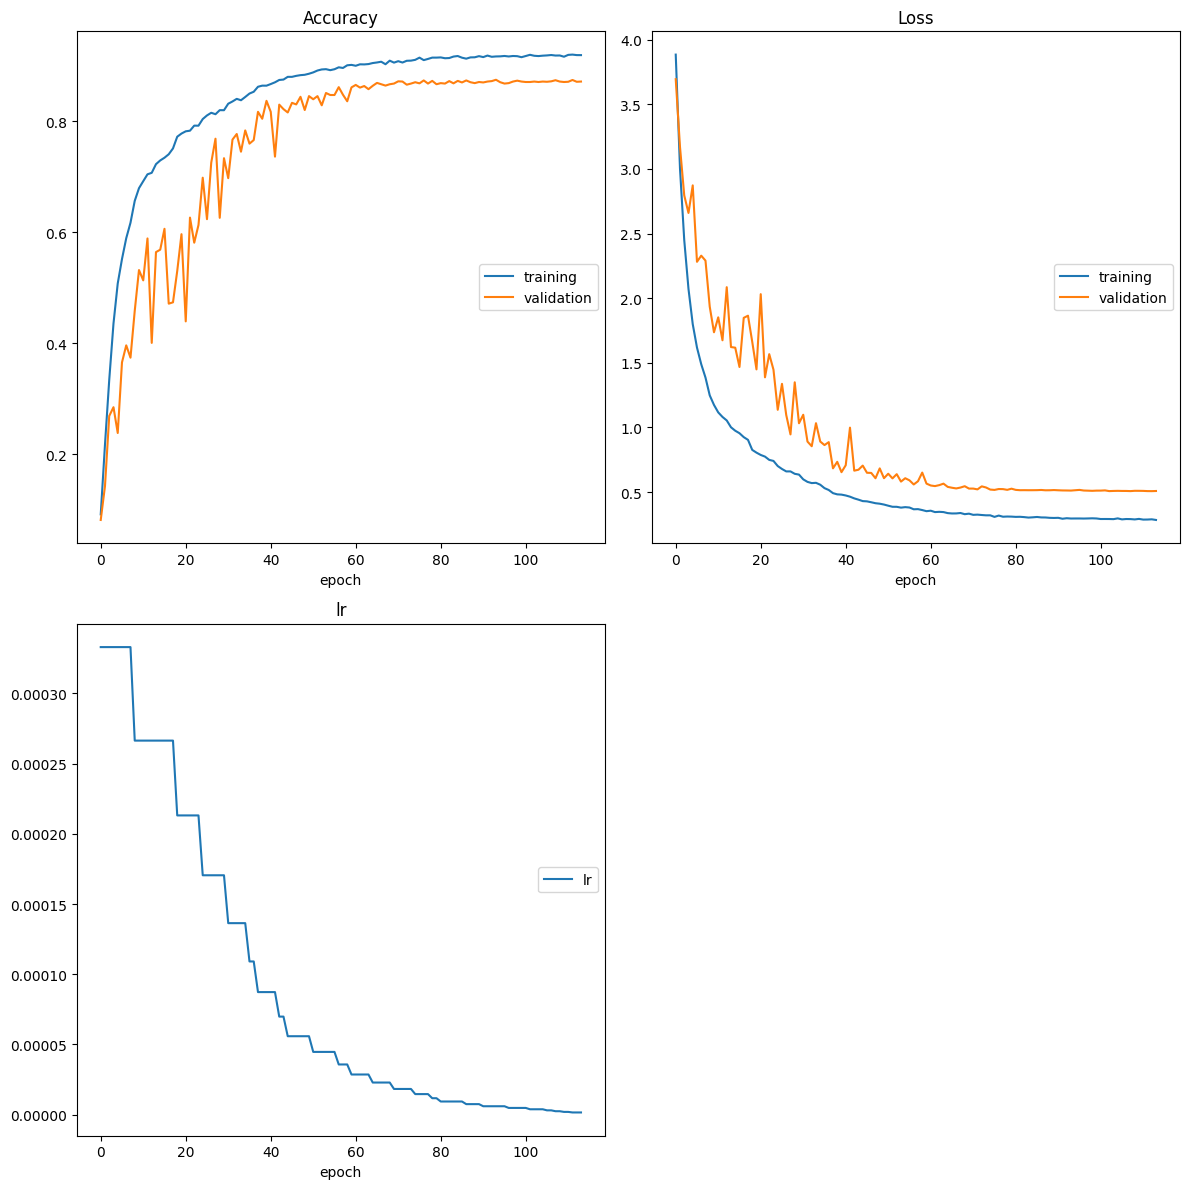

Accuracy
	training         	 (min:    0.091, max:    0.920, cur:    0.919)
	validation       	 (min:    0.081, max:    0.875, cur:    0.872)
Loss
	training         	 (min:    0.285, max:    3.884, cur:    0.285)
	validation       	 (min:    0.508, max:    3.694, cur:    0.509)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
174/174 [==============================] - 3s 17ms/step - loss: 0.2849 - acc: 0.9192 - val_loss: 0.5088 - val_acc: 0.8715 - lr: 1.5725e-06


In [24]:
history64 = model.fit(train_x64[train_index64], train_y64_mapped[train_index64],
                    validation_data=(train_x64[test_index64], train_y64_mapped[test_index64]),
                    epochs=EPOCHS, callbacks=cb_list, batch_size=BATCH_SIZE)

In [26]:
### eval
loss, acc = model.evaluate(train_x64[test_index64], train_y64_mapped[test_index64])
print(acc*100)

78/78 [==============================] - 0s 4ms/step - loss: 0.5121 - acc: 0.8747
87.47474551200867
